In [2]:
from tqdm import tqdm
import pickle
from time import time

import numpy as np
import scipy as scipy

import matplotlib.pyplot as plt

In [3]:
def get_rbk_step():
    def rbk_step(x, AS, bS):
        return x + np.linalg.lstsq(AS, bS - AS @ x, rcond=None)[0]

    return rbk_step


def get_reblock_step(lamb=0.001):
    def reblock_step(x, AS, bS):
        k = AS.shape[0]
        return x + AS.T @ scipy.linalg.solve(AS @ AS.T + lamb * k * np.eye(k), bS - AS @ x, assume_a='pos')

    return reblock_step
    

def get_minibatch_sgd_step(m, gamma=0.01):
    def minibatch_sgd_step(x, AS, bS):
        k = AS.shape[0]
        return x + gamma * AS.T @ (bS - AS @ x) / k

    return minibatch_sgd_step

In [4]:
def block_kaczmarz(A, b, k, T, take_step):
    m,n = A.shape
    x_kaczmarz = np.zeros(A.shape[1])
    xs = np.zeros((T+1, n))
    xs[0,:] = x_kaczmarz

    for t in tqdm(range(T)):
        S = np.random.choice(np.arange(m), size=k, replace=False)
        
        AS = A[S,:]
        bS = b[S]

        x_kaczmarz = take_step(x_kaczmarz, AS, bS)
        xs[t+1,:] = x_kaczmarz

    return xs

In [5]:
def plot_mean_residuals(data_list, Tburn, A, b, x_ls, plot_frequency=10, color_map={}):
    fig, ax = plt.subplots()

    opt = A @ x_ls - b
    opt_norm = np.linalg.norm(opt) 

    i = 0
    
    for (xs, label, style) in data_list:
        T = xs.shape[0] - 1

        # Create single array of individual iterates and then averaged iterates
        x_means = np.zeros_like(xs)
        x_means[0:Tburn,:] = xs[0:Tburn,:]
        x_means[Tburn:,:] = np.cumsum(xs[Tburn:,:],axis=0) / np.expand_dims(np.arange(1, T - Tburn + 2), 1)

        # Only plot a subset of the iterates to save computation on the residual calculations below
        x_means = x_means[::plot_frequency]
        it_values = plot_frequency * np.arange(x_means.shape[0])

        # Calculate residuals and epsilons
        res = x_means @ A.T - np.expand_dims(b, axis=0)
        eps = np.linalg.norm(res, axis=-1) / opt_norm - 1

        if label in color_map:
            ax.plot(it_values, eps, color=color_map[label], label=label, linestyle=style, linewidth=3)
        else:
            ax.plot(it_values, eps, label=label, linestyle=style, linewidth=3)


    ax.axvline(Tburn, color='black', dashes=[2,4], linewidth=0.5)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Suboptimality $\epsilon$')
    ax.legend(loc='upper right')
    ax.grid(axis='y')

    return fig, ax

<>:35: SyntaxWarning: invalid escape sequence '\e'
<>:35: SyntaxWarning: invalid escape sequence '\e'
/var/folders/6z/x6qspb9s42z6m5k2l4yw445c0000gn/T/ipykernel_33062/53898767.py:35: SyntaxWarning: invalid escape sequence '\e'
  ax.set_ylabel('Suboptimality $\epsilon$')


# RBK with Gaussian data

In [6]:
m=100000
n=100
noise_level=0.01

T = 10**4
k = 30

## Isotropic Gaussian problem

In [74]:
np.random.seed(0) 

# Generate random isotropic Gaussian problem
A = np.random.randn(m,n)

y = np.random.randn(n)
b = A @ y + noise_level * np.random.randn(m)

x_ls = np.linalg.lstsq(A, b, rcond=None)[0]

In [75]:
np.linalg.cond(A)

1.063635491810552

In [76]:
x_sgd = block_kaczmarz(A,b,k,T, get_minibatch_sgd_step(m, gamma=0.2))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:21<00:00, 467.27it/s]


100%|██████████| 10000/10000 [00:36<00:00, 273.52it/s]


In [77]:
x_rbk = block_kaczmarz(A,b,k,T, get_rbk_step())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 368.52it/s]


In [78]:
x_data = [x_sgd, x_rbk ]
labels = ['TA-mSGD', "TA-RBK-U"]
styles = ['dashed', 'solid']
Tburn = 300

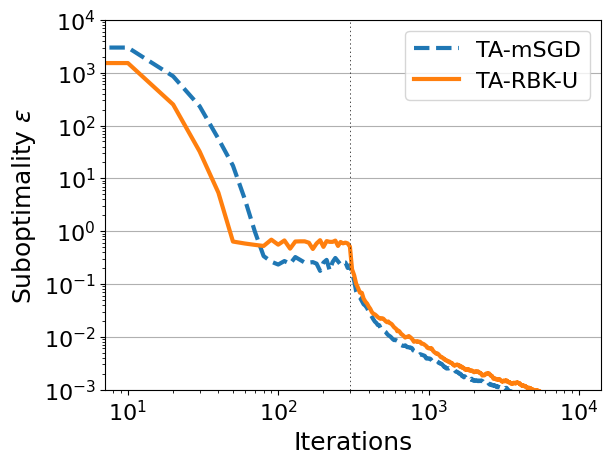

In [79]:
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'axes.labelsize': 18})

fig, ax = plot_mean_residuals(zip(x_data, labels,styles), Tburn, A, b, x_ls)
ax.set_ylim([1e-3, 1e4])
plt.savefig("isotropic_gaussian.pdf", bbox_inches='tight')

In [94]:
def plot_Tburns(data_list, A, b, x_ls, plot_frequency=10, color_map={}):
    fig, ax = plt.subplots()

    opt = A @ x_ls - b
    opt_norm = np.linalg.norm(opt) 

    i = 0
    
    for (xs, label, style, Tburn) in data_list:
        T = xs.shape[0] - 1

        # Create single array of individual iterates and then averaged iterates
        x_means = np.zeros_like(xs)
        x_means[0:Tburn,:] = xs[0:Tburn,:]
        x_means[Tburn:,:] = np.cumsum(xs[Tburn:,:],axis=0) / np.expand_dims(np.arange(1, T - Tburn + 2), 1)

        # Only plot a subset of the iterates to save computation on the residual calculations below
        x_means = x_means[::plot_frequency]
        it_values = plot_frequency * np.arange(x_means.shape[0])

        # Calculate residuals and epsilons
        res = x_means @ A.T - np.expand_dims(b, axis=0)
        eps = np.linalg.norm(res, axis=-1) / opt_norm - 1

        ax.axvline(Tburn, color='black', dashes=[2,4], linewidth=0.5)

        if label in color_map:
            ax.plot(it_values, eps, color=color_map[label], label=label, linestyle=style, linewidth=3)
        else:
            ax.plot(it_values, eps, label=label, linestyle=style, linewidth=3)


    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Suboptimality $\epsilon$')
    ax.legend(loc='upper right')
    ax.grid(axis='y')

    return fig, ax

<>:36: SyntaxWarning: invalid escape sequence '\e'
<>:36: SyntaxWarning: invalid escape sequence '\e'
/var/folders/6z/x6qspb9s42z6m5k2l4yw445c0000gn/T/ipykernel_33062/2985789694.py:36: SyntaxWarning: invalid escape sequence '\e'
  ax.set_ylabel('Suboptimality $\epsilon$')


In [95]:
x_data = [x_rbk, x_rbk, x_rbk ]
labels = ['$T_b=10$', "$T_b=100$", "$T_b=1000$"]
styles = ['dashed', 'solid', 'dashdot']
Tburns = [10, 100, 1000]
color_map = {'$T_b=10$': 'orange', '$T_b=100$': 'orange', '$T_b=1000$': 'orange'}

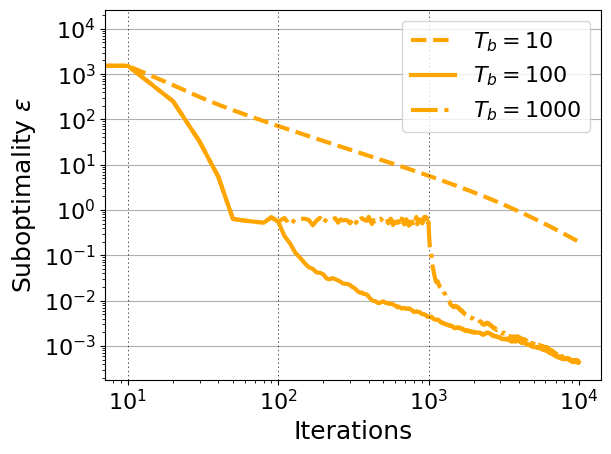

In [96]:
fig, ax = plot_Tburns(zip(x_data, labels,styles, Tburns), A, b, x_ls, color_map=color_map)
plt.savefig("Tburns.pdf", bbox_inches='tight')

## Gaussian problem with decaying singular values

In [34]:
np.random.seed(0) 

# Generate random Gaussian problem with singular value d ecay
M = np.random.randn(n, n)
Q1,_ = np.linalg.qr(M)
M = np.random.randn(n, n)
Q2,_ = np.linalg.qr(M)
U = Q1 @ np.diag(1 / np.arange(1,n+1)**2) @ Q2.T

A = np.random.randn(m,n) @ U

y = np.random.randn(n)
b = A @ y + noise_level * np.random.randn(m)

x_ls = np.linalg.lstsq(A, b,rcond=None)[0]

In [35]:
np.linalg.cond(A)

10012.96504123611

In [277]:
x_sgd = block_kaczmarz(A,b,k,T, get_minibatch_sgd_step(m, gamma=1.0))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:35<00:00, 278.04it/s]


In [278]:
x_rbk = block_kaczmarz(A,b,k,T, get_rbk_step())

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 256.18it/s]


In [279]:
x_data = [x_sgd, x_rbk ]
labels = ['TA-mSGD', "TA-RBK-U"]
styles = ['dashed', 'solid']
Tburn = 300

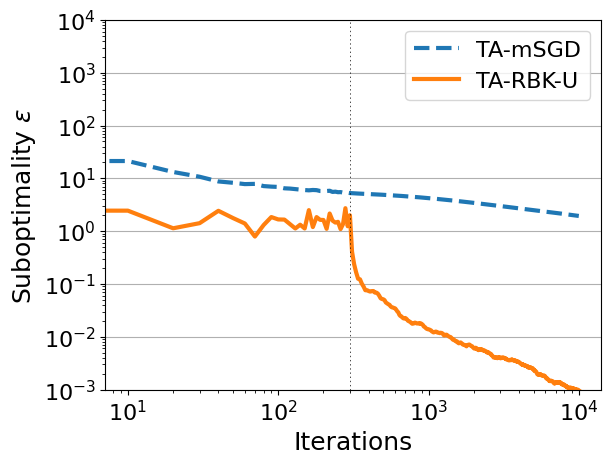

In [280]:
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'axes.labelsize': 18})

fig, ax = plot_mean_residuals(zip(x_data, labels, styles), Tburn, A, b, x_ls)
ax.set_ylim([1e-3, 1e4])
plt.savefig("decay_gaussian.pdf", bbox_inches='tight')

# Problems with ill-conditioned blocks

In [14]:
lamb = 0.001

## Mild singular value decay

In [10]:
np.random.seed(0) 

# Rows correspond to values in [-1,1] 
# Columns correspond to Chebyshev polynomials
cheb_inputs = np.linspace(-1, 1, m)
cheb_coeffs = np.eye(n)
cols = []

for i in range(n):
    ci_fn = np.polynomial.chebyshev.Chebyshev(cheb_coeffs[i,:])
    cols.append(ci_fn(cheb_inputs))

A = np.stack(cols, axis=-1)

y = np.random.randn(n)

b = A @ y + noise_level * np.random.randn(m)


x_ls = np.linalg.lstsq(A, b,rcond=None)[0]

In [283]:
np.linalg.cond(A)

11.055411653797583

In [284]:
x_sgd = block_kaczmarz(A,b,k,T, get_minibatch_sgd_step(m, gamma=0.5))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:40<00:00, 249.82it/s]


In [285]:
x_rbk = block_kaczmarz(A,b,k,T, get_rbk_step())

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:49<00:00, 202.27it/s]


In [286]:
x_reblock = block_kaczmarz(A,b,k,T, get_reblock_step(lamb=lamb))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 250.52it/s]


In [287]:
x_data = [x_sgd, x_rbk, x_reblock]
labels = ['TA-mSGD', "TA-RBK-U", "TA-ReBlocK-U"]
styles = ['dashed', 'dashdot', 'solid']
Tburn = 300

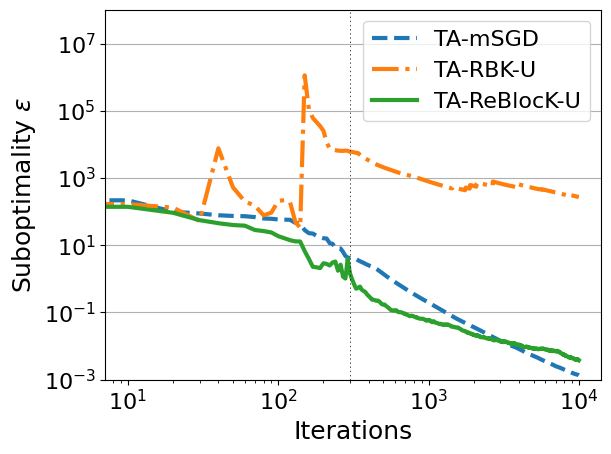

In [288]:
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'axes.labelsize': 18})

fig, ax = plot_mean_residuals(zip(x_data, labels, styles), Tburn, A, b, x_ls)
ax.legend(loc='upper right')
ax.set_ylim([1e-3, 1e8])
plt.savefig("chebyshev_mild_decay.pdf", bbox_inches='tight')

## Rapid singular value decay

In [9]:
np.random.seed(0) 

# Rows correspond to values in [-1,1] 
# Columns correspond to linear combinations of Chebyshev polynomials
cheb_inputs = np.linspace(-1, 1, m)
    
M = np.random.randn(n, n)


U,_ = np.linalg.qr(M)
M = np.random.randn(n, n)
V,_ = np.linalg.qr(M)
S =  1 / (np.arange(n) + 1) ** 2
cheb_coeffs = U @ np.diag(S) @ V

cols = []

for i in range(n):
    ci_fn = np.polynomial.chebyshev.Chebyshev(cheb_coeffs[i,:])
    cols.append(ci_fn(cheb_inputs))

A = np.stack(cols, axis=-1)

y = np.random.randn(n)
b = A @ y + noise_level * np.random.randn(m)

x_ls = np.linalg.lstsq(A, b,rcond=None)[0]

In [10]:
np.linalg.cond(A)

36580.42317797981

In [11]:
x_sgd = block_kaczmarz(A,b,k,T, get_minibatch_sgd_step(m, gamma=2.0))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:20<00:00, 487.53it/s]


In [12]:
x_rbk = block_kaczmarz(A,b,k,T, get_rbk_step())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 421.48it/s]


In [15]:
x_reblock = block_kaczmarz(A,b,k,T, get_reblock_step(lamb=lamb))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:20<00:00, 485.10it/s]


In [16]:
x_data = [x_sgd, x_rbk, x_reblock]
labels = ['TA-mSGD', "TA-RBK-U", "TA-ReBlocK-U"]
styles = ['dashed', 'dashdot', 'solid']
Tburn = 300

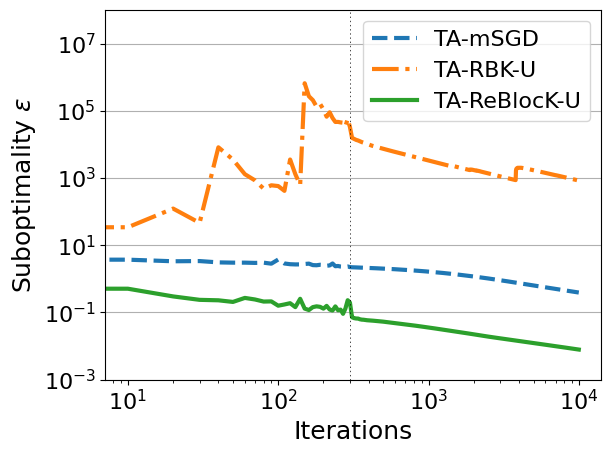

In [17]:
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'axes.labelsize': 18})

fig, ax = plot_mean_residuals(zip(x_data, labels, styles), Tburn, A, b, x_ls)
ax.legend(loc='upper right')

ax.set_ylim([1e-3, 1e8])
plt.savefig("chebyshev_fast_decay.pdf", bbox_inches='tight')

# Test inconsistency on previous problem

In [45]:
k = 30
noise_level = 0.1
np.random.seed(0) 

In [46]:
y = np.random.randn(n)
b = A @ y + noise_level * np.random.randn(m)

x_ls = np.linalg.lstsq(A, b,rcond=None)[0]

In [55]:
x_sgd = block_kaczmarz(A,b,k,T, get_minibatch_sgd_step(m, gamma=2.0))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 401.63it/s]


In [48]:
x_rbk = block_kaczmarz(A,b,k,T, get_rbk_step())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 394.35it/s]


In [49]:
x_reblock = block_kaczmarz(A,b,k,T, get_reblock_step(lamb=lamb))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 392.39it/s]


In [56]:
x_data = [x_sgd, x_rbk, x_reblock]
labels = ['TA-mSGD', "TA-RBK-U", "TA-ReBlocK-U"]
styles = ['dashed', 'dashdot', 'solid']
Tburn = 300

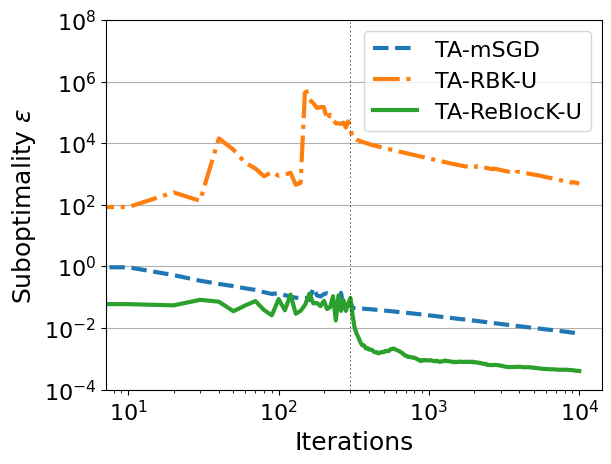

In [57]:
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'axes.labelsize': 18})

fig, ax = plot_mean_residuals(zip(x_data, labels, styles), Tburn, A, b, x_ls)
ax.legend(loc='upper right')

ax.set_ylim([1e-4, 1e8])
plt.savefig("noise_0_1.pdf", bbox_inches='tight')

In [83]:
noise_level = 0.01
np.random.seed(0) 

In [84]:
y = np.random.randn(n)
b = A @ y + noise_level * np.random.randn(m)

x_ls = np.linalg.lstsq(A, b,rcond=None)[0]

In [85]:
x_sgd = block_kaczmarz(A,b,k,T, get_minibatch_sgd_step(m, gamma=2.0))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:19<00:00, 506.27it/s]


In [86]:
x_rbk = block_kaczmarz(A,b,k,T, get_rbk_step())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 412.73it/s]


In [87]:
x_reblock = block_kaczmarz(A,b,k,T, get_reblock_step(lamb=lamb))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 396.99it/s]


In [88]:
x_data = [x_sgd, x_rbk, x_reblock]
labels = ['TA-mSGD', "TA-RBK-U", "TA-ReBlocK-U"]
styles = ['dashed', 'dashdot', 'solid']
Tburn = 300

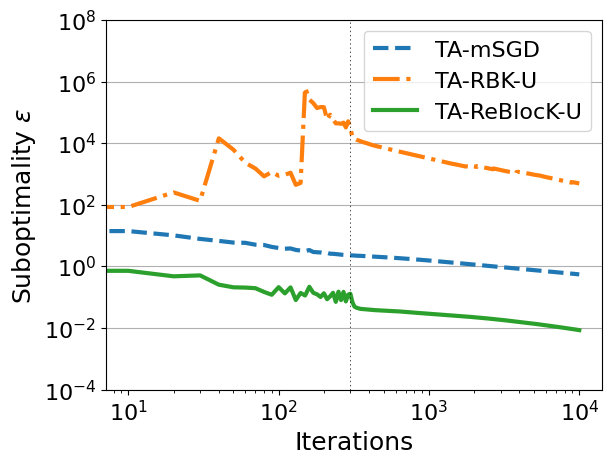

In [89]:
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'axes.labelsize': 18})

fig, ax = plot_mean_residuals(zip(x_data, labels, styles), Tburn, A, b, x_ls)
ax.legend(loc='upper right')

ax.set_ylim([1e-4, 1e8])
plt.savefig("noise_0_01.pdf", bbox_inches='tight')

In [58]:
noise_level = 0.001
np.random.seed(0) 

In [59]:
y = np.random.randn(n)
b = A @ y + noise_level * np.random.randn(m)

x_ls = np.linalg.lstsq(A, b,rcond=None)[0]

In [71]:
x_sgd = block_kaczmarz(A,b,k,T, get_minibatch_sgd_step(m, gamma=2.0))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 345.86it/s]


In [61]:
x_rbk = block_kaczmarz(A,b,k,T, get_rbk_step())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 423.70it/s]


In [62]:
x_reblock = block_kaczmarz(A,b,k,T, get_reblock_step(lamb=lamb))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 414.78it/s]


In [72]:
x_data = [x_sgd, x_rbk, x_reblock]
labels = ['TA-mSGD', "TA-RBK-U", "TA-ReBlocK-U"]
styles = ['dashed', 'dashdot', 'solid']
Tburn = 300

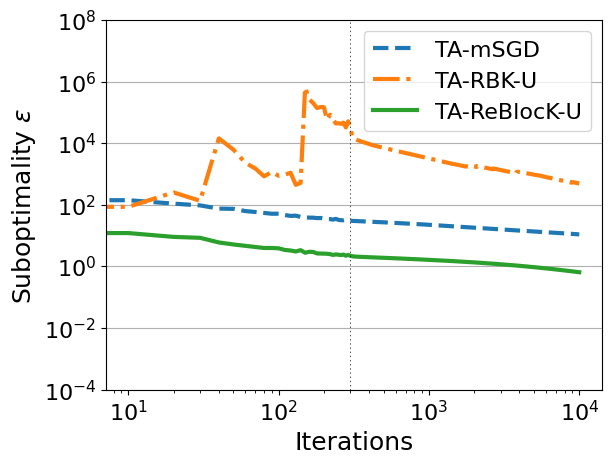

In [73]:
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'axes.labelsize': 18})

fig, ax = plot_mean_residuals(zip(x_data, labels, styles), Tburn, A, b, x_ls)
ax.legend(loc='upper right')

ax.set_ylim([1e-4, 1e8])
plt.savefig("noise_0_001.pdf", bbox_inches='tight')